## Thu Cao

Pose Dataset

In [82]:
import scipy.io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import os
import glob
import skimage
from scipy import io as spio
import numpy as np
import pandas as pd
import seaborn as sn
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter

sn.set()

from sklearn.svm import SVC # SVC
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
import keras
import warnings
warnings.filterwarnings("ignore")

# Loading The Dataset

In [83]:
#loading the dataset
pose = spio.loadmat('pose.mat')

In [84]:
pose['pose'].shape

(48, 40, 13, 68)

In [85]:
X = pose['pose'].transpose(3, 2, 1, 0)
X.shape

(68, 13, 40, 48)

In [86]:
X = np.vstack([np.expand_dims(X[x, y, :, :], axis=0) for x in range(68) for y in range(13)])
y = np.array([j for i in range(68) for j in range(13)])

In [87]:
X = np.vstack([np.concatenate(X[i], axis=0) for i in range(len(X))])

In [88]:
X.shape, y.shape

((884, 1920), (884,))

## Preprocessing the Data
Creating three different functions:<br>
- **resize** - This is created to resize the images in the given size
- **resize_images** - This is resize the given array of images
- **to_RGB** - This is used to convert the Black & White image into RGB image

In [89]:
def resize(image,size):
    image2 = np.zeros(size)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            image2[i+2,j+2] = image[i,j]
    return image2

def resize_images(array,size):
    
    for image in array:
        x=[]
        image2 = np.zeros(size)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                image2[i+2,j+2] = image[i,j]
            x.append(image2)
            
        finall = np.array(x)
        
    return finall

def to_RGB(image):
    shape = image.shape
    dim = np.zeros(shape)
    rr = np.stack((image,dim,dim),axis=2)
    return rr

In [90]:
x=[]
for image in X:
    x.append(cv2.resize(image,(32,32)))
train = np.array(x)

x=[]
for image in train:
    rr = to_RGB(image)
    x.append(rr)
train = np.array(x)

data = train/255.0

Creating input data for Inception V3, since it requires a minimum size of 75x75x3

In [91]:
x=[]
for image in X:
    x.append(cv2.resize(image,(75,75)))
train_inception = np.array(x)

x=[]
for image in train_inception:
    rr = to_RGB(image)
    x.append(rr)
train_inception = np.array(x)

data_inception = train_inception/255.0

One Hot Encoding the target variable using Keras in built function **to_categorical**

In [92]:
target = to_categorical(y)

# Splitting the Dataset to Train and Test set

In [93]:
data.shape,data_inception.shape,target.shape

((884, 32, 32, 3), (884, 75, 75, 3), (884, 13))

In [94]:
x_train = data[204:]
x_test = data[:204]
y_train = target[204:]
y_test = target[:204]

In [95]:
x_train_inception = data_inception[204:]
x_test_inception = data_inception[:204]
y_train_inception = target[204:]
y_test_inception = target[:204]

Checking the Shapes of Train and validation sets

In [96]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((680, 32, 32, 3), (680, 13), (204, 32, 32, 3), (204, 13))

In [97]:
x_train_inception.shape, y_train.shape, x_test_inception.shape, y_test.shape

((680, 75, 75, 3), (680, 13), (204, 75, 75, 3), (204, 13))

Function to plot training and validation accuracy and loss

In [98]:
def plot(history):
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = len(accuracy)

  plt.plot(range(epochs), accuracy, 'b', label='Training accuracy')
  plt.plot(range(epochs), val_accuracy, 'r', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(range(epochs), loss, 'b', label='Training Loss')
  plt.plot(range(epochs), val_loss, 'r', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## VGG16

In [99]:
base_model_vgg16 = VGG16(weights='imagenet',include_top=False,input_shape=(32, 32, 3))

# Freezing Layers
for layer in base_model_vgg16.layers:
    layer.trainable=False

# Building Model

model = Sequential()
model.add(base_model_vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 13)                3341      
Total params: 14,849,357
Trainable params: 134,669
Non-trainable params: 14,714,688
_________________________________________________________________


In [100]:
len(model.layers)

4

In [101]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [102]:
import time
t0=time.time()
vgg16_history  = model.fit(x_train,y_train,epochs=100,validation_split = 0.2,batch_size=16)
print("Time taken to train the model:", round(time.time()-t0, 2), "seconds")
print("==========================================")
print()

Train on 544 samples, validate on 136 samples
Epoch 1/100
544/544 [==============================] - 14s 26ms/sample - loss: 2.5919 - acc: 0.0551 - val_loss: 2.5429 - val_acc: 0.0809
Epoch 2/100
544/544 [==============================] - 14s 25ms/sample - loss: 2.5399 - acc: 0.0901 - val_loss: 2.5148 - val_acc: 0.2794
Epoch 3/100
544/544 [==============================] - 13s 25ms/sample - loss: 2.5037 - acc: 0.1654 - val_loss: 2.4624 - val_acc: 0.1691
Epoch 4/100
544/544 [==============================] - 14s 25ms/sample - loss: 2.4525 - acc: 0.1691 - val_loss: 2.3967 - val_acc: 0.2500
Epoch 5/100
544/544 [==============================] - 14s 25ms/sample - loss: 2.3775 - acc: 0.2279 - val_loss: 2.3152 - val_acc: 0.2647
Epoch 6/100
544/544 [==============================] - 14s 25ms/sample - loss: 2.3207 - acc: 0.2132 - val_loss: 2.2518 - val_acc: 0.3162
Epoch 7/100
544/544 [==============================] - 14s 25ms/sample - loss: 2.2172 - acc: 0.2960 - val_loss: 2.1739 - val_acc: 0.

In [103]:
t1=time.time()
model.evaluate(x_test,y_test)
print("Time taken to predict test cases:", round(time.time()-t1, 2), "seconds")
print("==========================================")
print()
#model.evaluate(x_test,y_test)

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The Test Set __Accuracy__ is __47.05%__

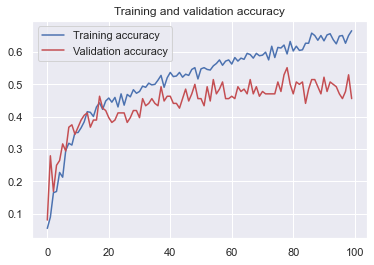

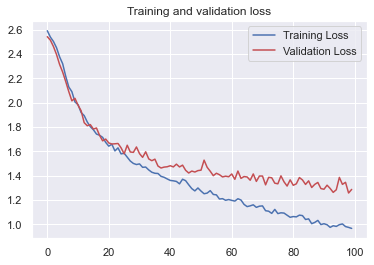

In [104]:
plot(vgg16_history)

### VGG19

We have changed the last fuly connected layer to have 10 neurons instead of the 4096 present in the architecture in order to classify images into ten different classes.

In [105]:
base_model_vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(32, 32, 3))

# Freezing Layers
for layer in base_model_vgg19.layers:
    layer.trainable=False

# Building Model

model = Sequential()
model.add(base_model_vgg19)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(13, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 13)                3341      
Total params: 20,159,053
Trainable params: 134,669
Non-trainable params: 20,024,384
_________________________________________________________________


In [132]:
len(model.layers)

4

In [106]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [107]:
t0=time.time()
vgg19_history  = model.fit(x_train,y_train,epochs=100,validation_split = 0.2,batch_size=16)
print("Time taken to train the model:", round(time.time()-t0, 2), "seconds")
print("==========================================")
print()


Train on 544 samples, validate on 136 samples
Epoch 1/100
544/544 [==============================] - 18s 33ms/sample - loss: 2.5839 - acc: 0.0662 - val_loss: 2.5424 - val_acc: 0.1029
Epoch 2/100
544/544 [==============================] - 17s 32ms/sample - loss: 2.5399 - acc: 0.0882 - val_loss: 2.5093 - val_acc: 0.1029
Epoch 3/100
544/544 [==============================] - 17s 31ms/sample - loss: 2.4980 - acc: 0.1379 - val_loss: 2.4556 - val_acc: 0.1985
Epoch 4/100
544/544 [==============================] - 17s 31ms/sample - loss: 2.4514 - acc: 0.1654 - val_loss: 2.4026 - val_acc: 0.2647
Epoch 5/100
544/544 [==============================] - 17s 31ms/sample - loss: 2.3522 - acc: 0.2721 - val_loss: 2.2655 - val_acc: 0.3382
Epoch 6/100
544/544 [==============================] - 17s 31ms/sample - loss: 2.2609 - acc: 0.2647 - val_loss: 2.2654 - val_acc: 0.2941
Epoch 7/100
544/544 [==============================] - 17s 31ms/sample - loss: 2.2037 - acc: 0.2574 - val_loss: 2.1772 - val_acc: 0.

In [108]:
t1=time.time()
model.evaluate(x_test,y_test)
print("Time taken to predict test cases:", round(time.time()-t1, 2), "seconds")
print("==========================================")
print()


204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The test set __Accuracy__ is __51.40%__

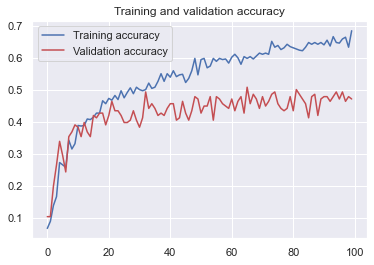

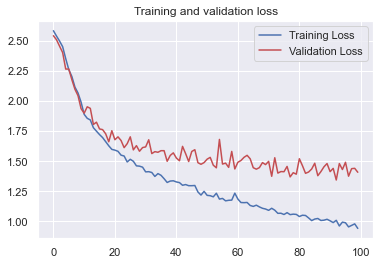

In [109]:
plot(vgg19_history)

# DenseNet 121

In [110]:
base_model_densenet121 = DenseNet121(weights='imagenet',include_top=False,input_shape=(32, 32, 3))

# Freezing Layers
for layer in base_model_densenet121.layers:
    layer.trainable=False

# Building Model

model_densenet_121 = Sequential()
model_densenet_121.add(base_model_densenet121)
model_densenet_121.add(Flatten())
model_densenet_121.add(Dense(64, activation='relu'))
model_densenet_121.add(Dense(64, activation='relu'))
model_densenet_121.add(Dense(32, activation='relu'))
model_densenet_121.add(Dense(32, activation='relu'))
model_densenet_121.add(Dense(13, activation='sigmoid'))

model_densenet_121.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1, 1, 1024)        7037504   
_________________________________________________________________
flatten_8 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                65600     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_26 (Dense)             (None, 13)               

In [131]:
len(model_densenet_121.layers)

7

In [112]:
model_densenet_121.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [113]:
t0=time.time()
densenet_121_history  = model_densenet_121.fit(x_train,y_train,epochs=100,validation_split = 0.2 )
print("Time taken to train the model:", round(time.time()-t0, 2), "seconds")
print("==========================================")
print()

Train on 544 samples, validate on 136 samples
Epoch 1/100
544/544 [==============================] - 13s 24ms/sample - loss: 2.5739 - acc: 0.0882 - val_loss: 2.5679 - val_acc: 0.0882
Epoch 2/100
544/544 [==============================] - 5s 8ms/sample - loss: 2.5573 - acc: 0.0938 - val_loss: 2.5707 - val_acc: 0.0956
Epoch 3/100
544/544 [==============================] - 5s 8ms/sample - loss: 2.5333 - acc: 0.1103 - val_loss: 2.5740 - val_acc: 0.0662
Epoch 4/100
544/544 [==============================] - 5s 9ms/sample - loss: 2.4932 - acc: 0.1489 - val_loss: 2.5835 - val_acc: 0.0882
Epoch 5/100
544/544 [==============================] - 5s 8ms/sample - loss: 2.4155 - acc: 0.1857 - val_loss: 2.6004 - val_acc: 0.0588
Epoch 6/100
544/544 [==============================] - 5s 9ms/sample - loss: 2.3136 - acc: 0.1949 - val_loss: 2.6702 - val_acc: 0.0956
Epoch 7/100
544/544 [==============================] - 5s 9ms/sample - loss: 2.2105 - acc: 0.2151 - val_loss: 2.7461 - val_acc: 0.0956
Epoch 8

In [114]:
t1=time.time()
model_densenet_121.evaluate(x_test,y_test)
print("Time taken to predict test cases:", round(time.time()-t1, 2), "seconds")
print("==========================================")
print()

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The Test Set __Accuracy__ is __51.47%__

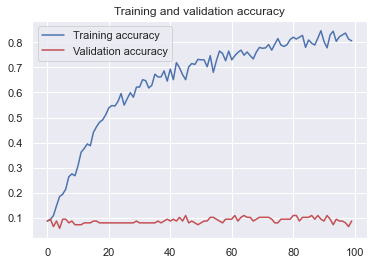

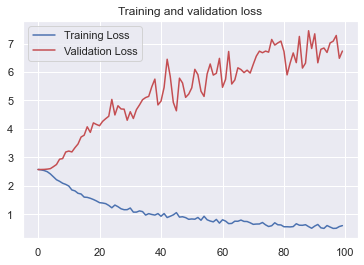

In [115]:
plot(densenet_121_history)

# DenseNet 169

In [116]:
base_model_densenet169 = DenseNet169(weights='imagenet',include_top=False,input_shape=(32, 32, 3))

# Freezing Layers
for layer in base_model_densenet169.layers:
    layer.trainable=False

# Building Model

model_densenet_169 = Sequential()
model_densenet_169.add(base_model_densenet169)
model_densenet_169.add(Flatten())
model_densenet_169.add(Dense(64, activation='relu'))
model_densenet_169.add(Dense(64, activation='relu'))
model_densenet_169.add(Dense(32, activation='relu'))
model_densenet_169.add(Dense(32, activation='relu'))
model_densenet_169.add(Dense(13, activation='sigmoid'))

model_densenet_169.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 1, 1, 1664)        12642880  
_________________________________________________________________
flatten_9 (Flatten)          (None, 1664)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                106560    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_31 (Dense)             (None, 13)              

In [130]:
len(model_densenet_169.layers)

7

In [118]:
model_densenet_169.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [119]:

t0=time.time()
densenet_169_history  = model_densenet_169.fit(x_train,y_train,epochs=100,validation_split = 0.2)
print("Time taken to train the model:", round(time.time()-t0, 2), "seconds")
print("==========================================")
print()


Train on 544 samples, validate on 136 samples
Epoch 1/100
544/544 [==============================] - 22s 40ms/sample - loss: 2.5727 - acc: 0.0809 - val_loss: 2.5687 - val_acc: 0.0588
Epoch 2/100
544/544 [==============================] - 6s 11ms/sample - loss: 2.5544 - acc: 0.0938 - val_loss: 2.5704 - val_acc: 0.0956
Epoch 3/100
544/544 [==============================] - 6s 11ms/sample - loss: 2.5221 - acc: 0.1066 - val_loss: 2.5729 - val_acc: 0.0809
Epoch 4/100
544/544 [==============================] - 6s 10ms/sample - loss: 2.4815 - acc: 0.1305 - val_loss: 2.5860 - val_acc: 0.0956
Epoch 5/100
544/544 [==============================] - 6s 11ms/sample - loss: 2.4205 - acc: 0.1489 - val_loss: 2.6026 - val_acc: 0.0882
Epoch 6/100
544/544 [==============================] - 6s 11ms/sample - loss: 2.3326 - acc: 0.1673 - val_loss: 2.6386 - val_acc: 0.0809
Epoch 7/100
544/544 [==============================] - 6s 11ms/sample - loss: 2.2890 - acc: 0.2371 - val_loss: 2.6757 - val_acc: 0.0882
E

In [120]:
t1=time.time()
model_densenet_169.evaluate(x_test,y_test)
print("Time taken to predict test cases:", round(time.time()-t1, 2), "seconds")
print("==========================================")
print()

204/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

The test set __Accuracy__ is __52.45%__

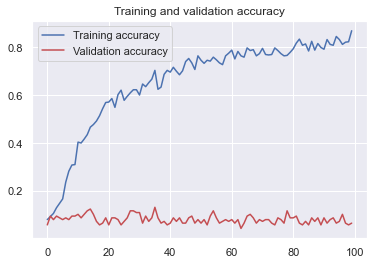

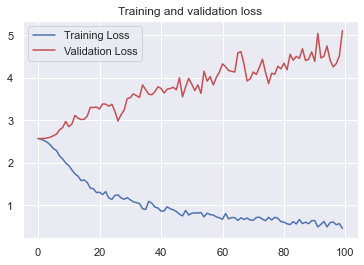

In [121]:
plot(densenet_169_history)

# AlexNet

In [ ]:
cnn_model = Sequential([
                                     
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(32,32,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),

    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')  
])
cnn_model.summary()

In [ ]:
len(cnn_model.layers)

In [ ]:
cnn_model.compile(loss = 'categorical_crossentropy',optimizer='adam', metrics = ['acc'])

In [ ]:

t0=time.time()
cnn_history  = cnn_model.fit(x_train,y_train,epochs=100,validation_split = 0.2 )
print("Time taken to train the model:", round(time.time()-t0, 2), "seconds")
print("==========================================")
print()



In [ ]:
t1=time.time()
cnn_model.evaluate(x_test,y_test)
print("Time taken to predict test cases:", round(time.time()-t1, 2), "seconds")
print("==========================================")
print()






The Test set **Accuracy** is **69.61%**

In [ ]:
plot(cnn_history)